<a href="https://colab.research.google.com/github/catmasteryip/Deep-Learning/blob/master/MNIST_ANN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [0]:
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [0]:
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline

In [0]:
# MNIST IMAGE --> Tensors

In [0]:
transform = transforms.ToTensor()


In [0]:
train_data = datasets.MNIST(root='sample_data',train=True,download=True,transform=transform)

Extracting sample_data/MNIST/raw/train-images-idx3-ubyte.gz to sample_data/MNIST/raw


Extracting sample_data/MNIST/raw/train-labels-idx1-ubyte.gz to sample_data/MNIST/raw


Extracting sample_data/MNIST/raw/t10k-images-idx3-ubyte.gz to sample_data/MNIST/raw




Extracting sample_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to sample_data/MNIST/raw
Processing...
Done!


/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


In [0]:
test_data=datasets.MNIST(root='sample_data',train=False,download=True,transform=transform)

In [0]:
test_data

Dataset MNIST
    Number of datapoints: 10000
    Root location: sample_data
    Split: Test
    StandardTransform
Transform: ToTensor()

In [0]:
type(train_data)

torchvision.datasets.mnist.MNIST

In [0]:
type(train_data[0])

tuple

In [0]:
image,label = train_data[0]

In [0]:
image.shape

torch.Size([1, 28, 28])

In [0]:
label

5

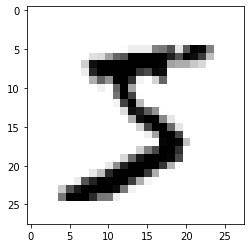

In [0]:
plt.imshow(image.reshape((28,28)),cmap='gist_yarg') #viridis

In [0]:
torch.manual_seed(101)
#0 images, 1 images, ...
train_loader = DataLoader(train_data,batch_size=100,shuffle=True)
#train_data = pytorch dataset object that supports data loading
test_loader = DataLoader(test_data,batch_size=500,shuffle=False)

In [0]:
from torchvision.utils import make_grid
np.set_printoptions(formatter=dict(int=lambda x: f'{x:4}'))

In [0]:
#first batch
for images, labels in train_loader:
  #60k images and 100 in a batch, do it 60 times
  break

In [0]:
images.shape

torch.Size([100, 1, 28, 28])

In [0]:
labels.shape

torch.Size([100])

In [0]:
print('Labels: ',labels[:12].numpy())

Labels:  [   0    5    7    8    6    7    9    7    1    3    8    4]


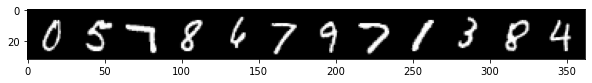

In [0]:
im = make_grid(images[:12],nrow=12)
plt.figure(figsize=(10,4))
#need to transpose the images from color channel, width, height to WHC
plt.imshow(np.transpose(im.numpy(),(1,2,0)))

In [0]:
class MLP(nn.Module):
  def __init__(self,in_sz=784,out_sz=10,layers=[120,84]):
    super().__init__()
    self.fc1 = nn.Linear(in_sz,layers[0])
    self.fc2 = nn.Linear(layers[0],layers[1])
    self.fc3 = nn.Linear(layers[1],out_sz)
  def forward(self,X):
    X = F.relu(self.fc1(X))
    X = F.relu(self.fc2(X))
    X = self.fc3(X)
    return F.log_softmax(X,dim=1) #multi-class classification

In [0]:
model = MLP()
model

MLP(
  (fc1): Linear(in_features=784, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [0]:
for param in model.parameters():
  print(param.numel())

94080
120
10080
84
840
10


In [0]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=0.001)

In [0]:
images.view(100,-1).shape

torch.Size([100, 784])

In [0]:
import time
start_time = time.time()
#Training

epochs = 10

#Trackers
train_losses = []
test_losses = []
train_correct = []
test_correct = []

for i in range(epochs):
  trn_corr = 0
  tst_corr = 0
  for b,(X_train,y_train) in enumerate(train_loader):
    b+=1
    y_pred = model(X_train.view(100,-1))
    loss = criterion(y_pred,y_train)
    #at last layer, find the max possibility class
    predicted = torch.max(y_pred.data,1)[1]
    batch_corr = (predicted == y_train).sum()
    trn_corr += batch_corr

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if b%200 == 0:
      acc = trn_corr.item()*100/(100*b)
      print(f'Epoch {i} batch {b} loss: {loss.item()} accuracy: {acc}')

  train_losses.append(loss)
  train_correct.append(trn_corr)

  with torch.no_grad():
    for b, (X_test, y_test) in enumerate(test_loader):
      y_val = model(X_test.view(500,-1))
      predicted = torch.max(y_val.data,1)[1]
      tst_corr += (predicted == y_test).sum()
  loss = criterion(y_val,y_test)
  test_losses.append(loss)
  test_correct.append(tst_corr)

total_time = time.time()-start_time
print(f'Duration: {total_time/60} mins')

Epoch 0 batch 200 loss: 0.3747691810131073 accuracy: 83.275
Epoch 0 batch 400 loss: 0.29840466380119324 accuracy: 87.6525
Epoch 0 batch 600 loss: 0.3232234716415405 accuracy: 89.73
Epoch 1 batch 200 loss: 0.2070380449295044 accuracy: 94.84
Epoch 1 batch 400 loss: 0.14979548752307892 accuracy: 95.1775
Epoch 1 batch 600 loss: 0.12238594144582748 accuracy: 95.44333333333333
Epoch 2 batch 200 loss: 0.11480630934238434 accuracy: 96.755
Epoch 2 batch 400 loss: 0.08137096464633942 accuracy: 96.7375
Epoch 2 batch 600 loss: 0.046609263867139816 accuracy: 96.82333333333334
Epoch 3 batch 200 loss: 0.07726575434207916 accuracy: 97.59
Epoch 3 batch 400 loss: 0.06995931267738342 accuracy: 97.585
Epoch 3 batch 600 loss: 0.10570508241653442 accuracy: 97.48166666666667
Epoch 4 batch 200 loss: 0.05103308707475662 accuracy: 97.99
Epoch 4 batch 400 loss: 0.06991414725780487 accuracy: 98.035
Epoch 4 batch 600 loss: 0.028907688334584236 accuracy: 98.04333333333334
Epoch 5 batch 200 loss: 0.01818772219121456

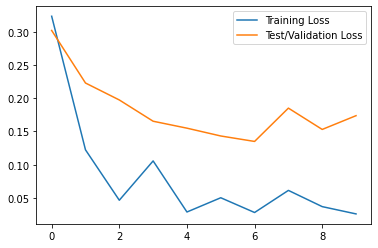

In [0]:
plt.plot(train_losses,label='Training Loss')
plt.plot(test_losses,label='Test/Validation Loss')
plt.legend()

In [0]:
train_acc = [t/600 for t in train_correct]

In [0]:
test_acc = [t/100 for t in test_correct]

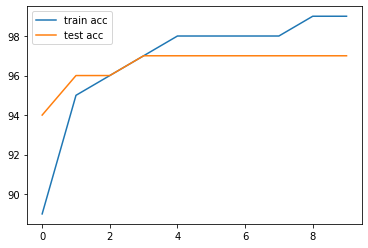

In [0]:
plt.plot(train_acc,label='train acc')
plt.plot(test_acc,label='test acc')
plt.legend()

In [0]:
test_load_all = DataLoader(test_data,batch_size=10000,shuffle=False)

In [0]:
with torch.no_grad():
  correct = 0
  for x_test,y_test in test_load_all:
    y_val = model(x_test.view(len(x_test),-1))
    predicted = torch.max(y_val,1)[1]
    correct += (predicted == y_test).sum()

In [0]:
100*correct.item()/len(test_data)

97.51